In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.3.0
GPU name: /device:GPU:0


# Sequence modelling 

## Coding tutorials
 #### 1.  The IMDb dataset
 #### 2. Padding and masking sequence data
 #### 3. The `Embedding` layer
 #### 4. The Embedding Projector
 #### 5. Recurrent neural network layers
 #### 6. Stacked RNNs and the `Bidirectional` wrapper

***
<a id="coding_tutorial_1"></a>
## The IMDb Dataset

#### Load the IMDB review sentiment dataset

In [ ]:
# Import imdb

import tensorflow.keras.datasets.imdb as imdb

In [ ]:
# Download and assign the data set using load_data()

(x_train,y_train),(x_test,y_test)=imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


#### Inspect the dataset

In [ ]:
# Inspect the type of the data

type(x_train)

numpy.ndarray

In [ ]:
# Inspect the shape of the data

x_train.shape

(25000,)

In [ ]:
# Display the first dataset element input
# Notice encoding
x_train[0]


In [ ]:
# Display the first dataset element output
y_train[0]
#1 means good review while 0 means bad review

1

#### Load dataset with different options

In [ ]:
# Load the dataset with defaults
imdb.load_data(path='imdb.npz',index_from=3)

# ~/.keras/dataset/

In [ ]:
# Limit the vocabulary to the top 500 words using num_words

imdb.load_data(num_words=500)

In [ ]:
# Ignore the top 10 most frequent words using skip_top

imdb.load_data(skip_top=10,num_words=1000,oov_char=2)

In [ ]:
# Limit the sequence lengths to 500 using maxlen
imdb.load_data(maxlen=500)


In [ ]:
 # Use '1' as the character that indicates the start of a sequence

 imdb.load_data(start_char=1)

#### Explore the dataset word index

In [ ]:
# Load the imdb word index using get_word_index()

imdb_word_index=imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
# View the word index as a dictionary,
# accounting for index_from.

index_from=3
imdb_word_index={key:value+index_from for key,value in imdb_word_index.items()}

In [ ]:
# Retrieve a specific word's index
imdb_word_index['simpsonian']


52256

In [ ]:
imdb_word_index['the']

4

In [ ]:
# View an input sentence

inv_imdb_word_index={value:key for key,value in imdb_word_index.items()}
[inv_imdb_word_index[index] for index in x_train[0] if index > index_from]

In [ ]:
# Get the sentiment value

y_train[0]

1

---
<a id="coding_tutorial_2"></a>
## Padding and Masking Sequence Data

In [ ]:
# Load the imdb data set

import tensorflow.keras.datasets.imdb as imdb
(x_train,y_train),(x_test,y_test)=imdb.load_data()

#### Preprocess the data with padding

In [ ]:
# Inspect the input data shape

x_train.shape

(25000,)

In [ ]:
# Pad the inputs to the maximum length using maxlen

padded_x_train=tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=300, padding='post', truncating='pre')

In [ ]:
# Inspect the output data shape
padded_x_train.shape


(25000, 300)

#### Create a Masking layer

In [ ]:
# Import numpy 
import numpy as np


In [ ]:
# Masking expects to see (batch, sequence, features)
# Create a dummy feature dimension using expand_dims

padded_x_train=np.expand_dims(padded_x_train,-1)

In [ ]:
# Create a Masking layer 

tf_x_train=tf.convert_to_tensor(padded_x_train,dtype='float32')
masking_layer=tf.keras.layers.Masking(mask_value=0.0)

In [ ]:
# Pass tf_x_train to it
masked_x_train=masking_layer(tf_x_train)


In [ ]:
# Look at the dataset

masked_x_train

In [ ]:
# Look at the ._keras_mask for the dataset

masked_x_train._keras_mask

<tf.Tensor: shape=(25000, 300), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

***
<a id="coding_tutorial_3"></a>
## The Embedding layer

#### Create and apply an `Embedding` layer

In [ ]:
# Create an embedding layer using layers.Embedding
# Specify input_dim, output_dim, input_length
embedding_layer=tf.keras.layers.Embedding(input_dim=501,output_dim=16)
#input_dim取数据集最大的index+1


In [ ]:
# Inspect an Embedding layer output for a fixed input
# Expects an input of shape (batch, sequence, feature)
sequence_of_indices=tf.constant([[0],[1],[5],[500]])
sequence_of_embedding=embedding_layer(sequence_of_indices)
sequence_of_embedding
#可以看见每个数都变成了16维的向量


<tf.Tensor: shape=(4, 1, 16), dtype=float32, numpy=
array([[[-0.0351886 , -0.04225677,  0.00723963, -0.04063572,
         -0.02244313,  0.04117281, -0.02695715, -0.01541322,
          0.00622575, -0.03228147,  0.0089018 ,  0.00649285,
         -0.0162809 ,  0.04343171,  0.02629206, -0.00578155]],

       [[ 0.03373902,  0.00431247,  0.0078531 , -0.02304307,
         -0.01635176,  0.01087022,  0.02670727, -0.0318986 ,
         -0.04323762, -0.00921321, -0.01175161,  0.04318789,
         -0.01193644, -0.04371834,  0.0473139 ,  0.04620228]],

       [[-0.04601118,  0.00297427, -0.04102536,  0.04183496,
         -0.02314423,  0.03651235, -0.04150898,  0.03843583,
         -0.01098391,  0.0488116 , -0.00279527,  0.02377072,
         -0.00663054, -0.03812705, -0.04075871,  0.04998956]],

       [[-0.01225165, -0.0344586 ,  0.02050069,  0.00498895,
         -0.0290748 ,  0.04811014,  0.00452006, -0.02867909,
         -0.02980425, -0.01832874,  0.03266776, -0.03630509,
         -0.04682275, -0

In [ ]:
# Inspect the Embedding layer weights using get_weights()

embedding_layer.get_weights()[0]

array([[-0.0351886 , -0.04225677,  0.00723963, ...,  0.04343171,
         0.02629206, -0.00578155],
       [ 0.03373902,  0.00431247,  0.0078531 , ..., -0.04371834,
         0.0473139 ,  0.04620228],
       [ 0.00883625,  0.00579286, -0.04566714, ...,  0.00800955,
        -0.02828377,  0.01074583],
       ...,
       [ 0.00980872, -0.04534034,  0.00235348, ..., -0.03503337,
        -0.03394075, -0.03288086],
       [ 0.00238824,  0.01602787,  0.04323497, ..., -0.01090812,
         0.02357885, -0.00530108],
       [-0.01225165, -0.0344586 ,  0.02050069, ..., -0.00809904,
         0.03842131, -0.00317272]], dtype=float32)

In [ ]:
# Get the embedding for the 14th index
embedding_layer.get_weights()[0][14,:]


array([ 0.0199802 , -0.03514288,  0.03902605, -0.02577883, -0.00896709,
       -0.0003801 , -0.0267513 ,  0.02140636,  0.01423961, -0.02727246,
        0.03004945, -0.04811574, -0.00654674, -0.03513432,  0.03497629,
       -0.00278237], dtype=float32)

#### Create and apply an `Embedding` layer that uses `mask_zero=True`

In [ ]:
# Create a layer that uses the mask_zero kwarg
masking_embedding_layer=tf.keras.layers.Embedding(input_dim=501,output_dim=16,mask_zero=True)


In [ ]:
# Apply this layer to the sequence and see the _keras_mask property
masked_of_sequence_embedding=masking_embedding_layer(sequence_of_indices)
masked_of_sequence_embedding._keras_mask

<tf.Tensor: shape=(4, 1), dtype=bool, numpy=
array([[False],
       [ True],
       [ True],
       [ True]])>

---
<a id="coding_tutorial_4"></a>
## The Embedding Projector

#### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load and preprocess the IMDb data

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train,y_train),(x_test,y_test)=get_and_pad_imdb_dataset()

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index
imdb_word_index=get_imdb_word_index()


In [ ]:
# Swap the keys and values of the word index

inv_imdb_word_index={value:key for key,value in imdb_word_index.items()}

In [ ]:
# View the first dataset example sentence

[inv_imdb_word_index[index] for index in x_train[100] if index>2]

['i',
 'am',
 'a',
 'great',
 'fan',
 'of',
 'david',
 'lynch',
 'and',
 'have',
 'everything',
 'that',
 "he's",
 'made',
 'on',
 'dvd',
 'except',
 'for',
 'hotel',
 'room',
 'the',
 '2',
 'hour',
 'twin',
 'peaks',
 'movie',
 'so',
 'when',
 'i',
 'found',
 'out',
 'about',
 'this',
 'i',
 'immediately',
 'grabbed',
 'it',
 'and',
 'and',
 'what',
 'is',
 'this',
 "it's",
 'a',
 'bunch',
 'of',
 'drawn',
 'black',
 'and',
 'white',
 'cartoons',
 'that',
 'are',
 'loud',
 'and',
 'foul',
 'mouthed',
 'and',
 'unfunny',
 'maybe',
 'i',
 "don't",
 'know',
 "what's",
 'good',
 'but',
 'maybe',
 'this',
 'is',
 'just',
 'a',
 'bunch',
 'of',
 'crap',
 'that',
 'was',
 'on',
 'the',
 'public',
 'under',
 'the',
 'name',
 'of',
 'david',
 'lynch',
 'to',
 'make',
 'a',
 'few',
 'bucks',
 'too',
 'let',
 'me',
 'make',
 'it',
 'clear',
 'that',
 'i',
 "didn't",
 'care',
 'about',
 'the',
 'foul',
 'language',
 'part',
 'but',
 'had',
 'to',
 'keep',
 'the',
 'sound',
 'because',
 'my',
 'ne

#### Build an Embedding layer into a model

In [ ]:
# Get the maximum token value
max_index_value=max(imdb_word_index.values())

10000

In [ ]:
# Specify an embedding dimension
embedding_dim=16


In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=False),
                           tf.keras.layers.GlobalAveragePooling1D(),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])
#the model will return the probability that the sequence is positive

In [ ]:
# Functional API refresher: use the Model to build the same model
review_sequence=tf.keras.Input((None,))
embedding_sequence=tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim)(review_sequence)
average_embedding=tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
positive_probability=tf.keras.layers.Dense(1,activation='sigmoid')(average_embedding)

model=tf.keras.Model(inputs=review_sequence,outputs=positive_probability)


In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### Compile, train, and evaluate the model

In [ ]:
# Compile the model with a binary cross-entropy loss

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Train the model using .fit(), savng its history

history=model.fit(x_train,y_train,epochs=5,batch_size=32,validation_data=(x_test,y_test),validation_steps=20)

Epoch 1/5
782/782 [==============================] - 6s 8ms/step - loss: 0.6897 - accuracy: 0.5513 - val_loss: 0.6843 - val_accuracy: 0.5328
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.6699 - accuracy: 0.6690 - val_loss: 0.6497 - val_accuracy: 0.6750
Epoch 3/5
782/782 [==============================] - 6s 8ms/step - loss: 0.6286 - accuracy: 0.7495 - val_loss: 0.6024 - val_accuracy: 0.7625
Epoch 4/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5784 - accuracy: 0.7912 - val_loss: 0.5557 - val_accuracy: 0.7703
Epoch 5/5
782/782 [==============================] - 6s 7ms/step - loss: 0.5307 - accuracy: 0.8152 - val_loss: 0.5113 - val_accuracy: 0.7984


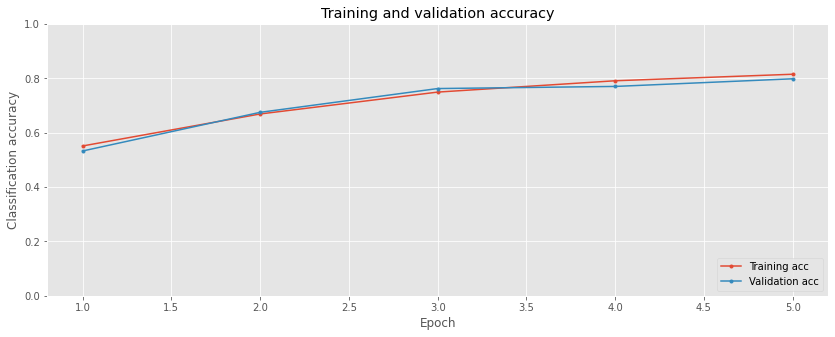

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### The TensorFlow embedding projector

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [ ]:
# Retrieve the embedding layer's weights from the trained model

weights=model.layers[1].get_weights()[0]

In [ ]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

out_v = io.open(path.join('data', 'vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('data', 'meta.tsv'), 'w', encoding='utf-8')

k = 0

for word, token in word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

#### Initialize and pass an input to a SimpleRNN layer

In [2]:
# Create a SimpleRNN layer and test it
simplernn_layer=tf.keras.layers.SimpleRNN(16)


In [4]:
# Note that only the final cell output is returned
sequence=tf.constant([[[1.,1.],[2.,2.],[56.,-100.]]])
layer_output=simplernn_layer(sequence)
layer_output


<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[-1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        , -1.        ,  1.        ,
        -0.65938175,  1.        , -1.        , -1.        ,  1.        ,
        -1.        ]], dtype=float32)>

#### Load and transform the IMDB review sentiment dataset

In [5]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [6]:
# Load the dataset

(x_train,y_train),(x_test,y_test)=get_and_pad_imdb_dataset(maxlen=250)


17465344/17464789 [==============================] - 0s 0us/step


In [7]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [8]:
# Get the word index using get_imdb_word_index()

imdb_word_index=get_imdb_word_index()

1646592/1641221 [==============================] - 0s 0us/step


#### Create a recurrent neural network model

In [9]:
# Get the maximum index value
max_index_values=max(imdb_word_index.values())
embedding_dim=16


In [10]:
# Using Sequential, build the model:
# 1. Embedding.
# 2. LSTM.
# 3. Dense.
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(input_dim=max_index_values+1, output_dim=embedding_dim, mask_zero=True),
                           tf.keras.layers.LSTM(16),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])



#### Compile and fit the model

In [11]:
# Compile the model with binary cross-entropy loss

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')

In [12]:
# Fit the model and save its training history

history=model.fit(x_train,y_train,epochs=3,batch_size=32)

Epoch 1/3
536/536 [==============================] - 278s 518ms/step - loss: 0.4483 - accuracy: 0.7883
Epoch 2/3
536/536 [==============================] - 275s 513ms/step - loss: 0.2404 - accuracy: 0.9082
Epoch 3/3
536/536 [==============================] - 276s 514ms/step - loss: 0.1689 - accuracy: 0.9394


#### Plot learning curves

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### Make predictions with the model

In [ ]:
# View the first test data example sentence
# (invert the word index)
inv_imdb_word_index={value:key for key,value in imdb_word_index.items()}
[inv_imdb_word_index[index] for index in x_test[0] if index>2]


In [15]:
# Get the model prediction using model.predict()

model.predict(x_test[None,0,:])
#(batch,sequence,fearture)

array([[0.1029188]], dtype=float32)

In [16]:
# Get the corresponding label

y_test[0]

0

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [17]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [18]:
# Load the dataset

(x_train,y_train),(x_test,y_test)=get_and_pad_imdb_dataset(num_words=50000,maxlen=250)

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [19]:
# Get the word index using get_imdb_word_index()
imdb_word_index=get_imdb_word_index(num_words=5000)


#### Build stacked and bidirectional recurrent models

In [20]:
# Get the maximum index value and specify an embedding dimension
max_index_values=max(imdb_word_index.values())
embedding_dim=16

In [21]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(input_dim=max_index_values+1, output_dim=embedding_dim, mask_zero=True),
                           tf.keras.layers.LSTM(32,return_sequences=True),
                           tf.keras.layers.LSTM(32,return_sequences=False),
                           tf.keras.layers.Dense(1, activation='sigmoid')
])

In [25]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(input_dim=max_index_values+1, output_dim=embedding_dim, mask_zero=True),
                           tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(8),merge_mode='sum',
                                                         backward_layer=tf.keras.layers.GRU(8,go_backwards=True)),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])
#如果bidirectional不写backward_layer则默认前后都在同一个layer进行

In [26]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(input_dim=max_index_values+1, output_dim=embedding_dim, mask_zero=True),
                           tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(8,return_sequences=True),merge_mode='concat'),
                           tf.keras.layers.GRU(8,return_sequences=False),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])


#### Compile and fit the model

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer='adam')


In [ ]:
# Train the model, saving its history

history=model.fit(x_train,y_train,epochs=3,batch_size=32)

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);